# Analyzing the Mercari children's book dataset

## Import libraries and files

In [14]:
%matplotlib notebook
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from sklearn.model_selection import train_test_split

os.chdir('/Users/mleong/github/used-books')
books = pd.read_csv('used-book-data.csv')



### Feature Engineering

In [23]:
# eliminate duplicate rows
books = books.drop_duplicates()

# id: convert to string
books.id = books.id.astype(str)

# posted: convert to datetime
books.posted = pd.to_datetime(books.posted)

# sold: combine buy now and add to cart categories to be 'for sale'
books = books.replace('Buy now', 'available')

# price: modify to eliminate '$' sign and convert to number
books['price'] = books['price'].str.replace(',', '')
books['price'] = books['price'].str.replace('$', '')
books['price'] = books['price'].astype(int)

# create new column "shipping_cost" that is continuous variable from $0 to whatever shipping fee is
def shipping_cost(shipping_string):
    shipping_after = shipping_string.split(" | ")
    if 'Free' in shipping_after[0]:
        shipping_cost = 0
    elif '$' in shipping_after[0]:
        shipping_cost = shipping_after[0]
        shipping_cost = shipping_cost.replace('$', '') 
    else:
        shipping_cost = None
    return shipping_cost
books['shipping_cost'] = books['shipping'].apply(shipping_cost)
books.shipping_cost = pd.to_numeric(books.shipping_cost, errors='coerce')

# create new simpler column "shipping_time" that is number of days to arrival
def shipping_time(shipping_string):
    if 'days' in shipping_string:
        shipping_after = shipping_string.split(" | ")
        if 'days' in shipping_after[0]:
            shipping_time = shipping_after[0]
            shipping_time = shipping_time.replace('+ days', '')
        elif 'days' in shipping_after[1]:
            shipping_time = shipping_after[1]
            shipping_time = shipping_time.replace('+ days', '')
        else:
            shipping_time = None
    else:
        shipping_time = None
    return shipping_time
books['shipping_time'] = books['shipping'].apply(shipping_time)

# create new simpler column "shipping_location" that is just the state product is coming from
def shipping_location(shipping_string):
    if 'from' in shipping_string:
        shipping_after = shipping_string.split(" | ")
        if 'from' in shipping_after[0]:
            shipping_location = shipping_after[0]
            shipping_location = shipping_location.replace('from ', '')
        elif 'from' in shipping_after[1]:
            shipping_location = shipping_after[1]
            shipping_location = shipping_location.replace('from ', '')
        elif 'from' in shipping_after[2]:
            shipping_location = shipping_after[2]
            shipping_location = shipping_location.replace('from ', '')
        else:
            shipping_location = None
    else:
        shipping_location = None
    return shipping_location
books['shipping_location'] = books['shipping'].apply(shipping_location)

# total price: new column that is sum of price and shipping fee
books['total_price'] = books['price']+books['shipping_cost']

# Making free_shipping column a yes/no
def free_shipping(shipping_cost):
    if shipping_cost == 0:
        free_shipping = 1
    else:
        free_shipping = 0
    return free_shipping
books['free_shipping'] = books.shipping_cost.apply(free_shipping)

# Making brand_included feature thats just a yes or no
books['brand_included'] = books.brand.notnull()
zeroANDones = lambda x: x*1
books.brand_included = books.brand_included.apply(zeroANDones)

# New column sold_true
def sold_true(status):
    if status == 'SOLD':
        sold_true = 1
    else:
        sold_true = 0
    return sold_true
books['sold_true'] = books.sold.apply(sold_true)

# New column summing of description length
def description_length(desc_string):
    description_length = len(desc_string)
    return description_length
books['description_length'] = books.description.apply(description_length)

# New column summing of title length
def title_length(title_string):
    title_length = len(title_string)
    return title_length
books['title_length'] = books.title.apply(title_length)

# New column condition_ordinal from new = 1, like new = 2, good = 3, fair = 4, poor = 5
def condition_ordinal(condition):
    if condition == "New":
        condition_ordinal = 1
    elif condition == "Like new":
        condition_ordinal = 2
    elif condition == "Good":
        condition_ordinal = 3
    elif condition == "Fair":
        condition_ordinal = 4
    elif condition == "Poor":
        condition_ordinal = 5
    else: condition_ordinal = None
    return condition_ordinal
books['condition_ordinal'] = books.condition.apply(condition_ordinal)

# New column days_since_posted. Was scraped on 2019-06-10 so range from 0 and up.
from datetime import date

def days_since_posted(posted):
    posted_day = date(posted.year, posted.month, posted.day)
    scrape_day = date(2019, 6, 10)
    days_since_posted = scrape_day - posted_day
    return days_since_posted.days
books['days_since_posted'] = books.posted.apply(days_since_posted)




AttributeError: Can only use .str accessor with string values, which use np.object_ dtype in pandas

In [16]:
# award winning people
geiselpeople = pd.read_csv('geiselpeople2.csv', encoding = "ISO-8859-1")
geiselpeople = geiselpeople.drop_duplicates()
geiselpeoplelist = geiselpeople['people'].tolist()

# amazon bestsellers
amazon = pd.read_csv('amazon.csv')
amazon = amazon.drop_duplicates()
amazonlist = amazon['amazon'].tolist()

# popular brands
popularbrands = ['disney','pixar', 'frozen', 'moana', 'toy story',
                 'americangirl', 'american girl',
                 'dr seuss', 'dr. seuss', 'drseuss', 'dr.seuss',
                 'lego', 'sesame street', 'sesamestreet', 'elmo', 'cookie monster', 'big bird',
                 'leap frog', 'leapfrog', 'minecraft', 'mine craft', 'marvel',
                 'spider-man', 'spiderman', 'hulk', 'iron man', 'thor', 'captain america',
                 'wolverine', 'black panther', 'doctor strange', 'captain marvel', 'black widow',
                 'scarlet witch', 'hawkeye', 'daredevil', 'silver surfer', 'avengers', 'xmen',
                 'x-men', 'deadpool', 'eric carle', 'hungry caterpillar', 'ericcarle', 
                 'nickelodean', 'starwars', 'star wars', 'jedi', 'yoda', 'darth vader', 
                 'winnie-the-pooh', 'winnie the pooh', 'tigger', 'eeyore', 
                 'harrypotter', 'harry potter', 'hogwarts', 'dumbledore', 'fanstastic beasts',
                 'diary of a wimpy kid', 'wimpy kid'
                ]
# Creating megastring!
def megastring(row):
  return (str(row['brand']) + " " + str(row['title']) + " " + str(row['description'])).lower()

books['megastring'] = books.apply(megastring, axis = 1)

def geiselpeople(megastring):
    """The Theodor Seuss Geisel Award is a literary award 
    by the American Library Association (ALA) that annually 
    recognizes the "author(s) and illustrator(s) of the most 
    distinguished book for beginning readers published in 
    English in the United States during the preceding year.
    All winning and nomineed authors/illustrators listed here
    """
    megalist = geiselpeoplelist
    megalist = [x.lower() for x in megalist]
    if any(word in megastring for word in megalist):
        return(1)
    else:
        return(0)
books['awardees'] = books.megastring.apply(geiselpeople)

def amazon(megastring):
    """amazon children's books best sellers list as of 18June2019.
    Kind of biased towards father's day, summer holiday travel,
    and summer holiday school work though
    """
    megalist = amazonlist
    megalist = [x.lower() for x in megalist]
    if any(word in megastring for word in megalist):
        return(1)
    else:
        return(0)
books['amazon'] = books.megastring.apply(amazon)

def topbrands(megastring):
    """the most frequently listed mercari brands
    and key words
    """
    megalist = popularbrands
    megalist = [x.lower() for x in megalist]
    if any(word in megastring for word in megalist):
        return(1)
    else:
        return(0)
books['topbrands'] = books.megastring.apply(topbrands)

# Feature engineering like what
def disney(megastring):
    if any(word in megastring for word in ['disney','pixar', 'frozen', 'moana', 'toy story' ]): 
        return(1)
    else:
        return(0)
books['disney'] = books.megastring.apply(disney)

def americangirl(megastring):
    if any(word in megastring for word in ['americangirl', 'american girl']): 
        return(1)
    else:
        return(0)
books['americangirl'] = books.megastring.apply(americangirl)

def seuss(megastring):
    if any(word in megastring for word in ['dr seuss', 'dr. seuss', 'drseuss', 'dr.seuss']): 
        return(1)
    else:
        return(0)
books['seuss'] = books.megastring.apply(seuss)

def lego(megastring):
    if any(word in megastring for word in ['lego']): 
        return(1)
    else:
        return(0)
books['lego'] = books.megastring.apply(lego)

def sesame(megastring):
    if any(word in megastring for word in ['sesame street', 'sesamestreet', 'elmo', 'cookie monster', 'big bird']): 
        return(1)
    else:
        return(0)
books['sesame'] = books.megastring.apply(sesame)

def leapfrog(megastring):
    if any(word in megastring for word in ['leap frog', 'leapfrog']): 
        return(1)
    else:
        return(0)
books['leapfrog'] = books.megastring.apply(leapfrog)

def minecraft(megastring):
    if any(word in megastring for word in ['minecraft', 'mine craft']): 
        return(1)
    else:
        return(0)
books['minecraft'] = books.megastring.apply(minecraft)

def marvel(megastring):
    if any(word in megastring for word in ['spider-man', 'spiderman', 'hulk', 'iron man', 'thor', 'captain america',
                                           'wolverine', 'black panther', 'doctor strange', 'captain marvel', 'black widow',
                                           'scarlet witch', 'hawkeye', 'daredevil', 'silver surfer', 'avengers', 'xmen',
                                           'x-men', 'deadpool']):
        return(1)
    else:
        return(0)
books['marvel'] = books.megastring.apply(marvel)
           
def ericcarle(megastring):
    if any(word in megastring for word in ['eric carle', 'hungry caterpillar', 'ericcarle']):
        return(1)
    else:
        return(0)
books['ericcarle'] = books.megastring.apply(ericcarle)
           
def nickelodean(megastring):
    if any(word in megastring for word in ['nickelodean']):
        return(1)
    else:
        return(0)
books['nickelodean'] = books.megastring.apply(nickelodean)

def starwars(megastring):
    if any(word in megastring for word in ['starwars', 'star wars', 'jedi', 'yoda', 'darth vader']):
        return(1)
    else:
        return(0)
books['starwars'] = books.megastring.apply(starwars)

def winniethepooh(megastring):
    if any(word in megastring for word in ['winnie-the-pooh', 'winnie the pooh', 'tigger', 'eeyore']):
        return(1)
    else:
        return(0)
books['winniethepooh'] = books.megastring.apply(winniethepooh)

def harrypotter(megastring):
    if any(word in megastring for word in ['harrypotter', 'harry potter', 'hogwarts', 'dumbledore', 'fanstastic beasts']):
        return(1)
    else:
        return(0)
books['harrypotter'] = books.megastring.apply(harrypotter)

def wimpykid(megastring):
    if any(word in megastring for word in ['diary of a wimpy kid', 'wimpy kid']):
        return(1)
    else:
        return(0)
books['wimpykid'] = books.megastring.apply(wimpykid)

def wimpykid(megastring):
    if any(word in megastring for word in ['diary of a wimpy kid', 'wimpy kid']):
        return(1)
    else:
        return(0)
books['wimpykid'] = books.megastring.apply(wimpykid)

def fisherprice(megastring):
    if any(word in megastring for word in ['fisherprice', 'fisher-price', 'fisher price']):
        return(1)
    else:
        return(0)
books['fisherprice'] = books.megastring.apply(fisherprice)

def scholastic(megastring):
    if any(word in megastring for word in ['scholastic']):
        return(1)
    else:
        return(0)
books['scholastic'] = books.megastring.apply(scholastic)

def bundle(megastring):
    if any(word in megastring for word in ['bundle', 'set of']):
        return(1)
    else:
        return(0)
books['bundle'] = books.megastring.apply(bundle)

def vintage(megastring):
    if any(word in megastring for word in ['vintage']):
        return(1)
    else:
        return(0)
books['vintage'] = books.megastring.apply(vintage)

def smokefree(megastring):
    if any(word in megastring for word in ['smokefree', 'smoke free', 'smoke-free', 'pet free', 'pet-free', 'petfree']):
        return(1)
    else:
        return(0)
books['smokefree'] = books.megastring.apply(smokefree)

def hardcover(megastring):
    if any(word in megastring for word in ['hard cover', 'hardcover', 'hard-cover']):
        return(1)
    else:
        return(0)
books['hardcover'] = books.megastring.apply(hardcover)



In [21]:
books_subset = books_filtered = books[((books.days_since_posted > 90) & (books.sold_true == 0)) | ((books.days_since_posted <= 90) & (books.sold_true == 1))]
books_subset.shape[0]

11773

## Modelling Time!

In [20]:
books.columns

Index(['brand', 'category', 'condition', 'description', 'id', 'posted',
       'price', 'seller_name', 'shipping', 'sold', 'title', 'shipping_cost',
       'shipping_time', 'shipping_location', 'total_price', 'free_shipping',
       'brand_included', 'sold_true', 'description_length', 'title_length',
       'condition_ordinal', 'days_since_posted', 'megastring', 'awardees',
       'amazon', 'topbrands', 'disney', 'americangirl', 'seuss', 'lego',
       'sesame', 'leapfrog', 'minecraft', 'marvel', 'ericcarle', 'nickelodean',
       'starwars', 'winniethepooh', 'harrypotter', 'wimpykid', 'fisherprice',
       'scholastic', 'bundle', 'vintage', 'smokefree', 'hardcover'],
      dtype='object')

In [45]:
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

#removing the days_since_posted feature because of subsetting
feature_names_books = ['condition_ordinal',
                       'total_price', 
#                        'price',
                       'free_shipping', 
                       'brand_included', 
                       'description_length', 
#                        'title_length',
#                        'disney', 
#                        'americangirl', 
#                        'seuss', 
#                        'lego', 
#                        'sesame', 
#                        'leapfrog', 
#                        'minecraft',
#                        'marvel', 
#                        'ericcarle', 
#                        'nickelodean', 
#                        'starwars', 
#                        'winniethepooh',
#                        'harrypotter', 
#                        'wimpykid', 
#                        'fisherprice', 
#                        'scholastic', 
#                        'bundle',
#                        'vintage', 
#                        'smokefree', 
#                        'hardcover',
#                        'awardees',
                         'topbrands',
#                         'amazon'
                      ]
X_books = books_subset[feature_names_books]
y_books = books_subset['sold_true']

X_train1, X_test_FINAL, y_train1, y_test_FINAL = train_test_split(X_books, y_books, random_state=0)
#X_train2, X_test, y_train2, y_test = train_test_split(X_train1, y_train1, random_state=0)

# SMOTE and ADASYN TO UPSAMPLE ON TRAINING DATA ONLY
X_sm, y_sm = SMOTE(random_state = 0).fit_resample(X_train1, y_train1)


rf_smote_train = RandomForestClassifier(max_depth = 4, min_samples_split = 10, n_estimators = 100, random_state=0).fit(X_sm, y_sm)
print('\nSMOTE INFLATED TRAINING DATASET')
print('Accuracy of RF classifier on training set: {:.4f}'.format(rf_smote_train.score(X_sm, y_sm)))
print('Accuracy of RF classifier on test set: {:.4f}'
     .format(rf_smote_train.score(X_test_FINAL, y_test_FINAL)))
rf_S_predicted = rf_smote_train.predict(X_test_FINAL)
rf_S_confusion = confusion_matrix(y_test_FINAL, rf_S_predicted)
print('Random Forest - SMOTE TRAINING DATASET \n', rf_S_confusion)
print(classification_report(y_test_FINAL, rf_S_predicted, target_names=['available', 'sold']))



SMOTE INFLATED TRAINING DATASET
Accuracy of RF classifier on training set: 0.8783
Accuracy of RF classifier on test set: 0.8444
Random Forest - SMOTE TRAINING DATASET 
 [[2428  415]
 [  43   58]]
              precision    recall  f1-score   support

   available       0.98      0.85      0.91      2843
        sold       0.12      0.57      0.20       101

   micro avg       0.84      0.84      0.84      2944
   macro avg       0.55      0.71      0.56      2944
weighted avg       0.95      0.84      0.89      2944



Try running again, but it looks like precision only went up marginally and recall actually went down! And subsets actually seem to be super important. Recall drops siginicantly when it's for all the data. So can't deal with date since posted feature. =(

### Great. As we can see above, even though accuracy looks better on the model trained with real uninflated data, the models trained with inflated data get much better recall for the sold data. Precision still isn't that great though.

In [169]:
# Cross validation scores
from sklearn.model_selection import cross_val_score

rf_cv_score = cross_val_score(rf_real_train, X_train1, y_train1, cv=10, scoring='roc_auc')

print("=== All AUC Scores ===")
print(rf_cv_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", rf_cv_score.mean())

=== All AUC Scores ===
[0.71824275 0.83174513 0.81153598 0.84696762 0.7298716  0.8292417
 0.83039247 0.70328273 0.78884358 0.87646036]


=== Mean AUC Score ===
Mean AUC Score - Random Forest:  0.7966583919507694


In [178]:
# Cross validation scores
from sklearn.model_selection import cross_val_score

rf_cv_score = cross_val_score(rf_real_train, X_test_FINAL, y_test_FINAL, cv=10, scoring='roc_auc')

print("=== All AUC Scores ===")
print(rf_cv_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", rf_cv_score.mean())

=== All AUC Scores ===
[0.77033493 0.77649123 0.78438596 0.8334507  0.70176056 0.73697183
 0.75633803 0.87165493 0.76830986 0.76443662]


=== Mean AUC Score ===
Mean AUC Score - Random Forest:  0.7764134656423389


In [177]:
# Cross validation scores
from sklearn.model_selection import cross_val_score

rf_cv_score = cross_val_score(rf_smote_train, X_test_FINAL, y_test_FINAL, cv=10, scoring='roc_auc')

print("=== All AUC Scores ===")
print(rf_cv_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest (with SMOTE): ", rf_cv_score.mean())

=== All AUC Scores ===
[0.77033493 0.77649123 0.78438596 0.8334507  0.70176056 0.73697183
 0.75633803 0.87165493 0.76830986 0.76443662]


=== Mean AUC Score ===
Mean AUC Score - Random Forest (with SMOTE):  0.7764134656423389


In [171]:
# Cross validation scores
from sklearn.model_selection import cross_val_score

rf_cv_score = cross_val_score(rf_smote_train, X_sm, y_sm, cv=10, scoring='roc_auc')

print("=== All AUC Scores ===")
print(rf_cv_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest (with SMOTE): ", rf_cv_score.mean())

=== All AUC Scores ===
[0.90850674 0.95755475 0.95341183 0.95414745 0.94402084 0.9528236
 0.95611573 0.94969602 0.95986171 0.95931331]


=== Mean AUC Score ===
Mean AUC Score - Random Forest (with SMOTE):  0.9495451968453248


In [172]:
# Cross validation scores
from sklearn.model_selection import cross_val_score

rf_cv_score = cross_val_score(rf_adasyn_train, X_ad, y_ad, cv=10, scoring='roc_auc')

print("=== All AUC Scores ===")
print(rf_cv_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest (with ADASYN): ", rf_cv_score.mean())

=== All AUC Scores ===
[0.89480556 0.95804834 0.95498908 0.94513157 0.94308136 0.96235848
 0.95960324 0.93540795 0.94562755 0.96545863]


=== Mean AUC Score ===
Mean AUC Score - Random Forest (with ADASYN):  0.9464511755052678


Wow these AUC scores from cross validation look really good! I need to create an AUC plot to include! 
=== All AUC Scores ===
[0.92420226 0.99231339 0.9944249  0.99324231 0.99734874 0.98448045
 0.98617653 0.99258983 0.99289677 0.95697637]


=== Mean AUC Score ===
Mean AUC Score - Random Forest:  0.9814651543780906

### Visualizing our winning model (SMOTE + Random Forest) AUC scores


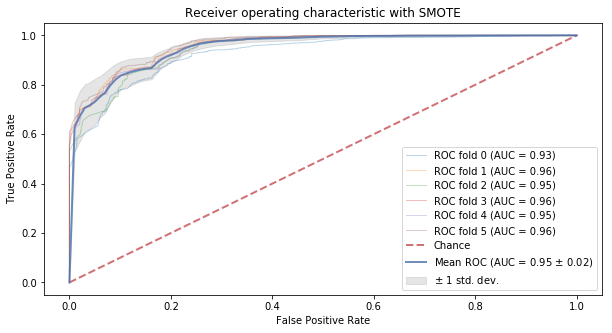

In [173]:
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

# Classification and ROC analysis

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=6)
classifier = RandomForestClassifier(max_depth = 4, min_samples_split = 10, n_estimators = 100, random_state=0)
#classifier = svm.SVC(kernel='linear', probability=True, random_state=random_state)




%matplotlib inline
from scipy import interp

plt.rcParams['figure.figsize'] = [10, 5]


i = 0
for train, test in cv.split(X_sm, y_sm):
    probas_ = classifier.fit(X_sm[train], y_sm[train]).predict_proba(X_sm[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with SMOTE')
plt.legend(loc="lower right")
plt.show()

## FIRST ATTEMPT AT RECALL-PRECISION CURVES

f1=0.181 auc=0.110 ap=0.107


<IPython.core.display.Javascript object>


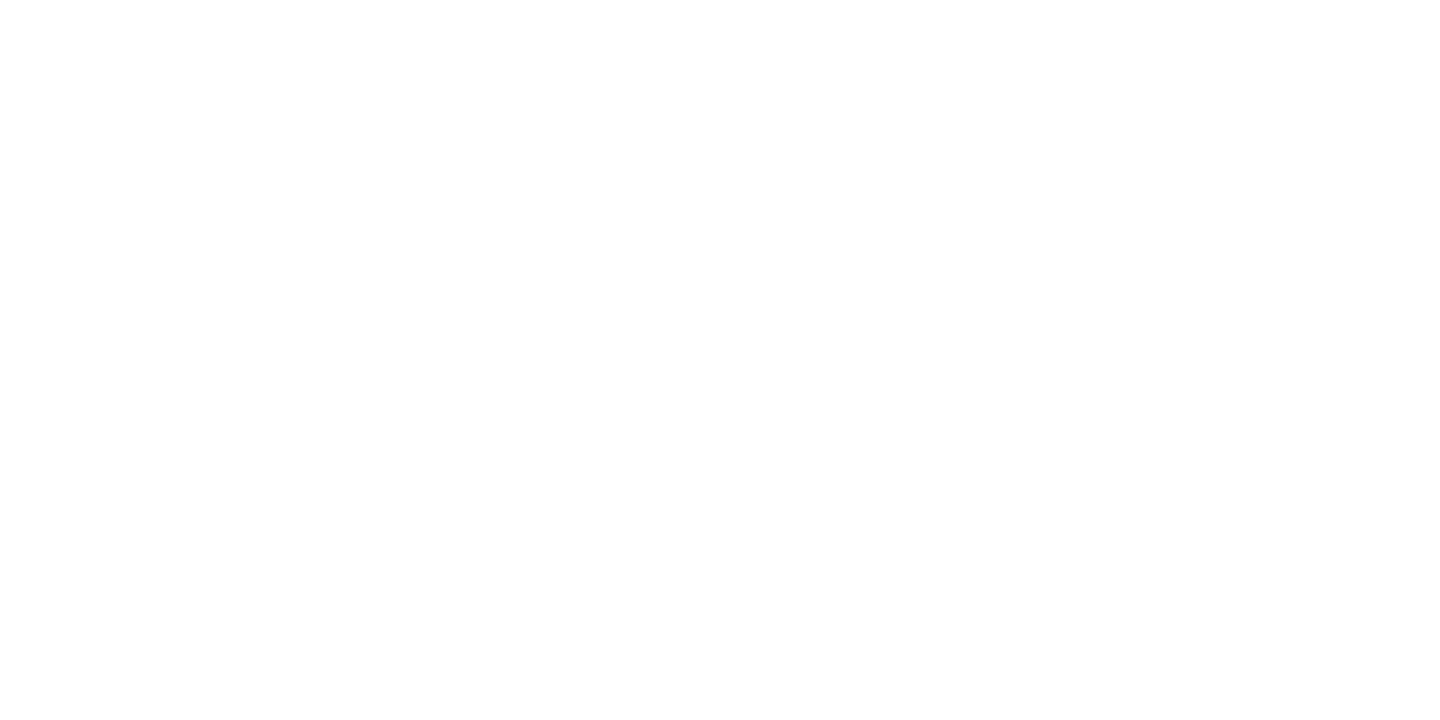

<IPython.core.display.Javascript object>


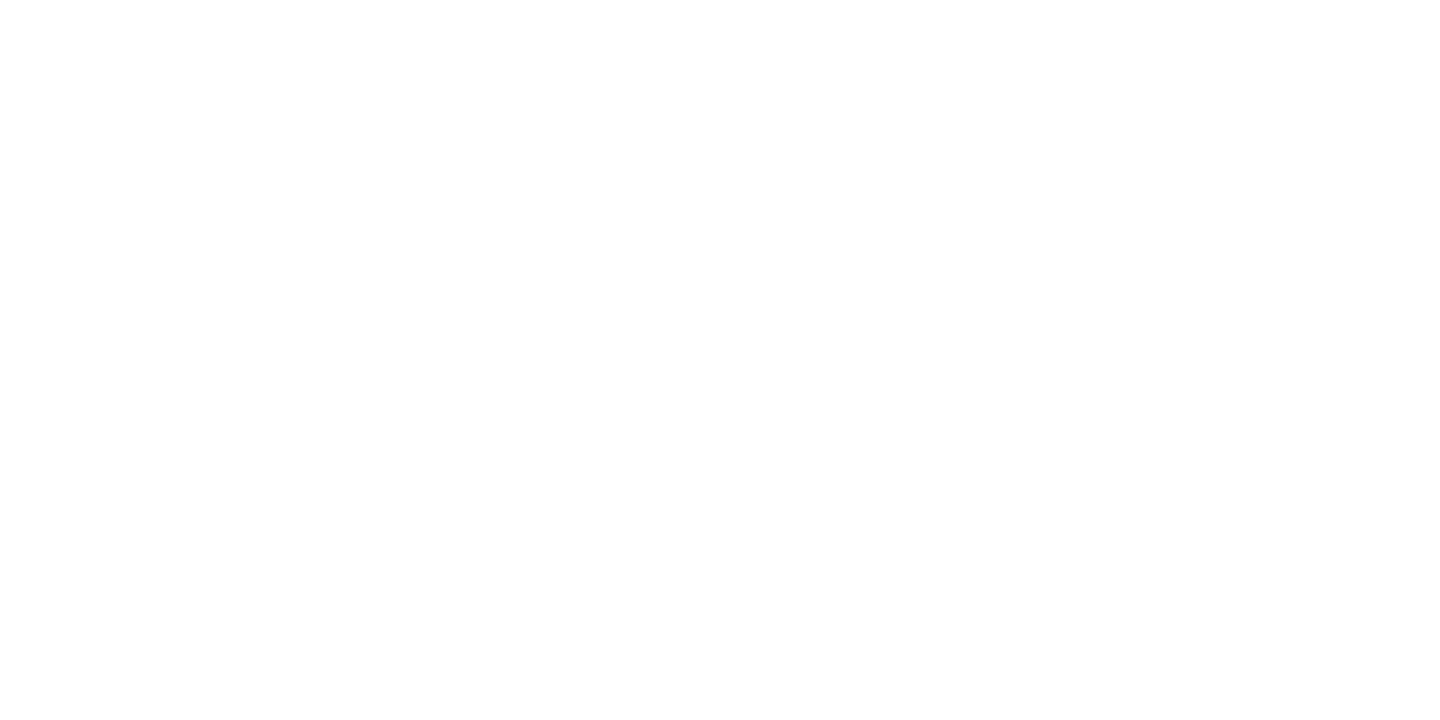

In [408]:
# from https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
# precision-recall curve and f1

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from matplotlib import pyplot


# predict probabilities
probs = rf_smote_train.predict_proba(X_test_FINAL)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# predict class values
yhat = rf_smote_train.predict(X_test_FINAL)
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test_FINAL, probs)
# calculate F1 score
f1 = f1_score(y_test_FINAL, yhat)
# calculate precision-recall AUC
auc = auc(recall, precision)
# calculate average precision score
ap = average_precision_score(y_test_FINAL, probs)
print('f1=%.3f auc=%.3f ap=%.3f' % (f1, auc, ap))
# plot no skill
pyplot.plot([0, 1], [0.5, 0.5], linestyle='--')
# plot the precision-recall curve for the model
pyplot.plot(recall, precision, marker='.')
# show the plot
pyplot.show()

In [54]:
print("Column names: ", str(feature_names_books))

Column names:  ['condition_ordinal', 'total_price', 'free_shipping', 'brand_included', 'description_length']


In [27]:
%matplotlib inline
importances = rf_smote_train.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
# Pritn features: 
X_train
# Print the feature ranking
print("Feature ranking:")

for f in range(X_train_scaled.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()



NameError: name 'rf' is not defined

Strange. Free shipping and including a Brand are some of the most important features. Sklearns features importances has been criticized as being biased because it inflates the importance of continuous or high cardinality variables which isn't the case with either of these features.

Strange. Free shipping and including a Brand are some of the most important features.

## FINAL CHECKS

In [78]:
X_test.iloc[3,]

condition_ordinal       1.0
total_price            18.0
free_shipping           1.0
brand_included          0.0
description_length    250.0
Name: 240, dtype: float64

In [176]:
features = [[3,7,1,1,200]]
prediction = rf.predict(features)
print(prediction)

[1]


In [68]:
print('Accuracy of RF classifier on ORIGINAL subtest set: {:.4f}'
     .format(rf.score(X_test_FINAL, y_test_FINAL)))

rf_predicted = rf.predict(X_test_FINAL)
rf_confusion = confusion_matrix(y_test_FINAL, rf_predicted)

print('Random Forest \n', rf_confusion)

Accuracy of RF classifier on ORIGINAL subtest set: 0.9385
Random Forest 
 [[2753   90]
 [  91   10]]


## HOW TO SAVE MODEL FOR WEB APP

In [46]:
import pickle
pickle.dump(rf_smote_train, open('model.pkl', 'wb'))



 
# some time later...
# load the model from disk
#loaded_model = pickle.load(open('model.pkl', 'rb'))
#result = loaded_model.score(X_test, Y_test)
#print(result)

### Gradient-Boosted Decision Trees

In [24]:
from sklearn.ensemble import GradientBoostingClassifier

gbdt = GradientBoostingClassifier(learning_rate = 0.01, max_depth = 2, random_state = 0)
gbdt.fit(X_train_scaled, y_train)
print('(learning_rate=0.01, max_depth=2)')
print('Accuracy of GBDT classifier on training set: {:.4f}'
     .format(gbdt.score(X_train_scaled, y_train)))
print('Accuracy of GBDT classifier on test set: {:.4f}'
     .format(gbdt.score(X_test_scaled, y_test)))

gbdt_predicted = gbdt.predict(X_test_scaled)
gbdt_confusion = confusion_matrix(y_test, gbdt_predicted)

print('Gradient-Boosted Decision Trees \n', gbdt_confusion)

(learning_rate=0.01, max_depth=2)
Accuracy of GBDT classifier on training set: 0.8257
Accuracy of GBDT classifier on test set: 0.8304
Gradient-Boosted Decision Trees 
 [[2382  484]
 [ 481 2344]]


## Evaluating these metrics with alternative models

In [25]:
from sklearn.metrics import classification_report

print('Dummy predictor (most frequent) \n', classification_report(y_test, dummy_majority_predicted, target_names=['available', 'sold']))
print('KNN \n', classification_report(y_test, knn_predicted, target_names=['available', 'sold']))
print('Logistic regression\n', classification_report(y_test, logreg_predicted, target_names = ['available', 'sold']))
print('SVC\n', classification_report(y_test, svc_predicted, target_names = ['available', 'sold']))
print('Naive Bayes\n', classification_report(y_test, nb_predicted, target_names = ['available', 'sold']))
print('Random Forest\n', classification_report(y_test, rf_predicted, target_names = ['available', 'sold']))
print('Gradient-Boosted Decision Trees\n', classification_report(y_test, gbdt_predicted, target_names = ['available', 'sold']))

Dummy predictor (most frequent) 
               precision    recall  f1-score   support

   available       0.50      0.50      0.50      2866
        sold       0.50      0.50      0.50      2825

   micro avg       0.50      0.50      0.50      5691
   macro avg       0.50      0.50      0.50      5691
weighted avg       0.50      0.50      0.50      5691

KNN 
               precision    recall  f1-score   support

   available       0.94      0.93      0.93      2866
        sold       0.93      0.94      0.93      2825

   micro avg       0.93      0.93      0.93      5691
   macro avg       0.93      0.93      0.93      5691
weighted avg       0.93      0.93      0.93      5691

Logistic regression
               precision    recall  f1-score   support

   available       0.76      0.79      0.77      2866
        sold       0.78      0.75      0.76      2825

   micro avg       0.77      0.77      0.77      5691
   macro avg       0.77      0.77      0.77      5691
weighted avg 

### Dummy Classifier

In [63]:
from sklearn.dummy import DummyClassifier

dummy_majority = DummyClassifier(strategy = 'stratified').fit(X_train, y_train)
print(dummy_majority.score(X_test, y_test))

dummy_majority_predicted = dummy_majority.predict(X_test)
confusion = confusion_matrix(y_test, dummy_majority_predicted)

print('Random class-proportional prediction (dummy classifier)\n', confusion)

0.49592391304347827
Random class-proportional prediction (dummy classifier)
 [[1074 1067]
 [  32   35]]


In [47]:
print('Accuracy of dummy classifier on ORIGINAL subtest set: {:.4f}'
     .format(dummy_majority.score(X_test1, y_test1)))

dummy_majority_predicted = dummy_majority.predict(X_test1_scaled)
dummy_majority_confusion = confusion_matrix(y_test1, dummy_majority_predicted)

print('Dummy Majority \n', dummy_majority_confusion)

Accuracy of dummy classifier on ORIGINAL subtest set: 0.4966
Dummy Majority 
 [[1362 1481]
 [  43   58]]


### KNN

I don't think it's reliable to use KNN and SMOTE simultaneously because SMOT may use the KNN method to upsample

In [33]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train_scaled, y_train)
print('Accuracy of K-NN classifier on training set: {:.4f}'
     .format(knn.score(X_train_scaled, y_train)))
print('Accuracy of K-NN classifier on test set: {:.4f}'
     .format(knn.score(X_test_scaled, y_test)))

knn_predicted = knn.predict(X_test_scaled)
knn_confusion = confusion_matrix(y_test, knn_predicted)

print('KNN\n', knn_confusion)

Accuracy of K-NN classifier on training set: 0.9357
Accuracy of K-NN classifier on test set: 0.9065
KNN
 [[3594  372]
 [ 369 3593]]


### Logistic Regression

In [34]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(solver = 'lbfgs').fit(X_train_scaled, y_train)

print('Accuracy of Logistic regression classifier on training set: {:.4f}'
     .format(logreg.score(X_train_scaled, y_train)))
print('Accuracy of Logistic regression classifier on test set: {:.4f}'
     .format(logreg.score(X_test_scaled, y_test)))

logreg_predicted = logreg.predict(X_test_scaled)
logreg_confusion = confusion_matrix(y_test, logreg_predicted)

print('Logistic Regression\n', logreg_confusion)

Accuracy of Logistic regression classifier on training set: 0.5654
Accuracy of Logistic regression classifier on test set: 0.5711
Logistic Regression
 [[1964 2002]
 [1398 2564]]


### Ridge Regression with Feature Normalization

In [35]:
from sklearn.linear_model import Ridge

linridge = Ridge(alpha=20.0).fit(X_train_scaled, y_train)

print('ridge regression linear model intercept: {}'
     .format(linridge.intercept_))
print('ridge regression linear model coeff:\n{}'
     .format(linridge.coef_))
print('R-squared score (training): {:.3f}'
     .format(linridge.score(X_train_scaled, y_train)))
print('R-squared score (test): {:.3f}'
     .format(linridge.score(X_test_scaled, y_test)))
print('Number of non-zero features: {}'
     .format(np.sum(linridge.coef_ != 0)))



ridge regression linear model intercept: 0.311721747825589
ridge regression linear model coeff:
[0.02179547 0.6513468  0.16073864 0.02921111 0.08021726]
R-squared score (training): 0.033
R-squared score (test): 0.041
Number of non-zero features: 5


### SVC

In [36]:
from sklearn.svm import LinearSVC

svc = LinearSVC().fit(X_train_scaled, y_train)
print('Accuracy of Linear SVC classifier on training set: {:.4f}'
     .format(svc.score(X_train_scaled, y_train)))
print('Accuracy of Linear SVC classifier on test set: {:.4f}'
     .format(svc.score(X_test_scaled, y_test)))

svc_predicted = svc.predict(X_test_scaled)
svc_confusion = confusion_matrix(y_test, svc_predicted)

print('SVC \n', svc_confusion)

Accuracy of Linear SVC classifier on training set: 0.5649
Accuracy of Linear SVC classifier on test set: 0.5706
SVC 
 [[1960 2006]
 [1398 2564]]


### Naive Bayes

In [37]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB().fit(X_train_scaled, y_train)
print('Accuracy of GaussianNB classifier on training set: {:.4f}'
     .format(nb.score(X_train_scaled, y_train)))
print('Accuracy of GaussianNB classifier on test set: {:.4f}'
     .format(nb.score(X_test_scaled, y_test)))

nb_predicted = nb.predict(X_test_scaled)
nb_confusion = confusion_matrix(y_test, nb_predicted)

print('Naive Bayes \n', nb_confusion)

Accuracy of GaussianNB classifier on training set: 0.6091
Accuracy of GaussianNB classifier on test set: 0.6126
Naive Bayes 
 [[3003  963]
 [2108 1854]]
